In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import math
import seaborn as sns
sns.set_palette('Set2')
import matplotlib.pyplot as plt
import re

In [2]:
telecom_df = pd.read_csv('telecom_churn_data.csv')
print(telecom_df.head(5))
print(telecom_df.shape) #(99999, 226)
print(telecom_df.info()) 

   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816 

## Preprocessing

#### Date column formatting

In [3]:
#print(telecom_df.select_dtypes(include=['object']).head())
#These are all of type data, of format mm/dd/yyyy, conver to dates
#for all date columns, keep only the day of the month, since month is present in the
#column name, year is common for all.
date_columns = list(telecom_df.select_dtypes(include=['object']).columns)
for column in date_columns:
    telecom_df[column] = pd.to_datetime(telecom_df[column], format='%m/%d/%Y')
    telecom_df[column] = telecom_df[column].dt.day

#### Identify Redundant columns

In [4]:
#Find columns with only single non-null value
redundant_cols = [col for col in telecom_df.columns if telecom_df[col].nunique()==1]
telecom_df = telecom_df.drop(redundant_cols, axis=1)
print('Following columns were removed: \n',redundant_cols)

Following columns were removed: 
 ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


#### Identifying the top 30 percentile in terms of total recharge done in month 6 and 7 (good phase)

In [5]:
#Those who have recharged with an amount more than or equal to X, 
#where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
'''
print(telecom_df['total_rech_amt_6'].isnull().sum()) 0;
print(telecom_df['total_rech_amt_7'].isnull().sum()) 0;
print(telecom_df['total_rech_num_6'].isnull().sum()) 0;
print(telecom_df['total_rech_num_7'].isnull().sum()) 0;
'''
#since, all values for the columns used below are non-nulls, we need not do any imputation here
if 'av_rech_67' not in list(telecom_df.columns):
    telecom_df['av_rech_67'] =  (telecom_df['total_rech_amt_6']+telecom_df['total_rech_amt_7'])/(telecom_df['total_rech_num_6']+telecom_df['total_rech_num_7'])
    avg_70_quantile = telecom_df.av_rech_67.quantile(q=0.7)
    telecom_df = telecom_df[telecom_df.av_rech_67>= avg_70_quantile]
print ('Data is now at 70th quantile of average recharge for the first 2 months. Total rows remaining: '+ str(len(telecom_df)))

Data is now at 70th quantile of average recharge for the first 2 months. Total rows remaining: 29944


#### Null value analysis


In [6]:
telecom_df.isnull().sum().describe()
# telecom_df.isnull().sum()>0).sum()
# 166 columns with missing values
# A lot of values are missing in many colums. Cannot remove such rows. Will have to find a way to impute

count      211.000000
mean      4459.331754
std       7413.617374
min          0.000000
25%          0.000000
50%        989.000000
75%       2083.000000
max      19826.000000
dtype: float64

##### Nullvalue imputation for internet-data based columns

In [7]:
for month in [6,7,8,9]:
    max_rech_data = 'max_rech_data_'+str(month)
    av_rech_amt_data='av_rech_amt_data_'+str(month)
    total_rech_data = 'total_rech_data_'+str(month)
    date_of_last_rech_data = 'date_of_last_rech_data_'+str(month)
    count_rech_3g = 'count_rech_3g_'+str(month)
    count_rech_2g = 'count_rech_2g_'+str(month)
    arpu_3g = 'arpu_3g_'+str(month)
    arpu_2g = 'arpu_2g_'+str(month)
    fb_user = 'fb_user_'+str(month)
    night_pck_user = 'night_pck_user_' +str(month)

    #Verify, that if toatl rech_data is null, then max, av, date, count_3g, count_2g are null too 
    #nonnullrows = np.sum(np.sum(telecom_df[telecom_df[total_rech_data].isnull()]
    #if last date for data recharge is null, then verify if other elements corresponding to null are null/0 too. If yes,
    # we can assign all of them as 0.
    
    max_rech_nonzerorows = len(telecom_df[(telecom_df[date_of_last_rech_data].isnull()) & ((~telecom_df[max_rech_data].isnull()) | (telecom_df[max_rech_data]>0))])
    if max_rech_nonzerorows == 0:
        telecom_df.loc[telecom_df[date_of_last_rech_data].isnull(),max_rech_data] = 0

    #Similarily for rest columns too
    assumption=True
    for data_colm in [total_rech_data, av_rech_amt_data,count_rech_3g,count_rech_2g,arpu_3g,arpu_2g,fb_user,night_pck_user]:
        rech_colm_nonzerorows = len(telecom_df[(telecom_df[date_of_last_rech_data].isnull()) & ((~telecom_df[data_colm].isnull()) | (telecom_df[data_colm]>0))])
        if rech_colm_nonzerorows == 0:
            telecom_df.loc[telecom_df[date_of_last_rech_data].isnull(),data_colm] = 0
        else:
            assumption = False
            print('Wrong assumption for', data_colm)
    if assumption == True:
#       If assumption was correct, then provide invalid date, or -ve
        telecom_df.loc[telecom_df[date_of_last_rech_data].isnull(),date_of_last_rech_data] = -1

##### Nullvalue imputation for basic recharge based columns

In [8]:
def makeZeroIfTotalIsZero(colm, total_colm, typeofcol):
    total_ = np.sum(telecom_df[telecom_df[colm].isnull()][total_colm])
    if total_ == 0:
        #('Total for ', typeofcol, ' is 0. Hence make all null values 0')
        telecom_df.loc[telecom_df[colm].isnull(),colm] = 0

for month in [6,7,8,9]:
    total_ic_mou = 'total_ic_mou_'+str(month)
    roam_ic_mou = 'roam_ic_mou_'+str(month)
    loc_ic_t2t_mou = 'loc_ic_t2t_mou_'+str(month)
    loc_ic_t2m_mou = 'loc_ic_t2m_mou_'+str(month)
    loc_ic_t2f_mou = 'loc_ic_t2f_mou_'+str(month)
    loc_ic_mou  = 'loc_ic_mou_'+str(month)
    std_ic_t2t_mou = 'std_ic_t2t_mou_'+str(month)
    std_ic_t2m_mou = 'std_ic_t2m_mou_'+str(month)
    std_ic_t2f_mou = 'std_ic_t2f_mou_'+str(month)
    std_ic_mou  =  'std_ic_mou_'+str(month)
    spl_ic_mou = 'spl_ic_mou_'+str(month)
    isd_ic_mou = 'isd_ic_mou_'+str(month)
    ic_others  = 'ic_others_'+str(month)

    total_og_mou = 'total_og_mou_' + str(month)
    roam_og_mou = 'roam_og_mou_' + str(month)
    loc_og_t2t_mou = 'loc_og_t2t_mou_' + str(month)
    loc_og_t2m_mou = 'loc_og_t2m_mou_' + str(month)
    loc_og_t2f_mou = 'loc_og_t2f_mou_' + str(month)
    loc_og_t2c_mou = 'loc_og_t2c_mou_' + str(month)
    loc_og_mou = 'loc_og_mou_' + str(month)
    std_og_t2t_mou = 'std_og_t2t_mou_' + str(month)
    std_og_t2m_mou = 'std_og_t2m_mou_' + str(month)
    std_og_t2f_mou = 'std_og_t2f_mou_' + str(month)
    std_og_mou = 'std_og_mou_' + str(month)
    isd_og_mou = 'isd_og_mou_' + str(month)
    spl_og_mou = 'spl_og_mou_' + str(month)
    og_others = 'og_others_' + str(month)
      
    onnet_mou = 'onnet_mou_'+str(month)
    offnet_mou = 'offnet_mou_'+str(month)

    date_of_last_rech = 'date_of_last_rech_' + str(month)
    total_rech_amt = 'total_rech_amt_'+ str(month)
    #Incoming columns
    for colm in [roam_ic_mou, loc_ic_t2t_mou, loc_ic_t2m_mou, 
                 loc_ic_t2f_mou, loc_ic_mou, std_ic_t2t_mou, 
                 std_ic_t2m_mou, std_ic_t2f_mou, std_ic_mou,
                 spl_ic_mou, isd_ic_mou, ic_others]:
        makeZeroIfTotalIsZero(colm, total_ic_mou, 'incoming')
    
    #Outgoing columns

    for colm in [roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,
                 loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,
                 std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,
                 std_og_mou,isd_og_mou,spl_og_mou,og_others]:
        makeZeroIfTotalIsZero(colm, total_ic_mou, 'outgoing')
    
    #Onnet columns
    #If outgoing + incoming mou for the nuxll entries is 0, then onnet, offnet mou are also 0
    outgoing_mou_when_onnet_null = np.sum(telecom_df[telecom_df[onnet_mou].isnull()][total_og_mou])
    incoming_mou_when_onnet_null = np.sum(telecom_df[telecom_df[onnet_mou].isnull()][total_ic_mou])
    onnet = outgoing_mou_when_onnet_null+incoming_mou_when_onnet_null
    #'Total onnet(calculated) for month: ', str(month), ' is: ', onnet, ' Actual null'..... #0
    telecom_df.loc[telecom_df[onnet_mou].isnull(),onnet_mou] = 0
    
    outgoing_mou_when_offnet_null = np.sum(telecom_df[telecom_df[offnet_mou].isnull()][total_og_mou])
    incoming_mou_when_offnet_null = np.sum(telecom_df[telecom_df[offnet_mou].isnull()][total_ic_mou])
    offnet = outgoing_mou_when_offnet_null+incoming_mou_when_offnet_null
    #'Total offnet(calculated) for month: ', str(month), ' is: ', offnet, ' Actual null'.... #0
    telecom_df.loc[telecom_df[offnet_mou].isnull(),offnet_mou] = 0
    
    
    total_ = np.sum(telecom_df[telecom_df[date_of_last_rech].isnull()][total_rech_amt])
    if total_ == 0:
        telecom_df.loc[telecom_df[date_of_last_rech].isnull(),date_of_last_rech] = -1

In [9]:
#Verify there are no null values remaining
print (0 == (telecom_df.isnull().sum()>0).sum()) # True

True


## Feature Engineering

### 1. Target variable (Churn)

In [10]:
#Identify churners now
telecom_df['churn'] = np.zeros(len(telecom_df))
telecom_df.loc[((telecom_df['total_ic_mou_9'] == 0) & 
                           (telecom_df['total_og_mou_9'] == 0) &
                           (telecom_df['vol_2g_mb_9'] == 0) &
                           (telecom_df['vol_3g_mb_9'] == 0) 
               ),'churn'] = 1
#Remove everything with _9
colms_with_9 = [colm for colm in telecom_df.columns if colm.endswith('_9')]
telecom_df = telecom_df.drop(colms_with_9, axis=1)

In [11]:
telecom_df.churn.value_counts().values.tolist()

[27342, 2602]

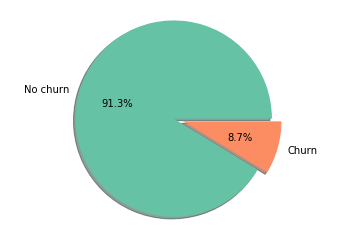

In [12]:
fig1, ax1 = plt.subplots()
values = telecom_df.churn.value_counts().values.tolist()
labels = ["No churn", "Churn"]
explode = [0,0.1]
ax1.pie(values,labels=labels, explode = explode,autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

### 2. Recency variables

In [13]:
telecom_df['recency_goodphase'] = np.ones(len(telecom_df))*61
telecom_df['recency_data_goodphase'] = np.ones(len(telecom_df))*61
#Regular recharge
telecom_df.loc[telecom_df.date_of_last_rech_7>0,'recency_goodphase']= 31 - telecom_df[telecom_df.date_of_last_rech_7 > 0].date_of_last_rech_7
telecom_df.loc[(telecom_df.date_of_last_rech_7<0)&(telecom_df.date_of_last_rech_6>0),'recency_goodphase']= 31 + (30 - telecom_df[(telecom_df.date_of_last_rech_7<0)&(telecom_df.date_of_last_rech_6 > 0)].date_of_last_rech_6)
                                                                            
                 
#Data recharge
telecom_df.loc[telecom_df.date_of_last_rech_data_7>0,'recency_data_goodphase']= 31 - telecom_df[telecom_df.date_of_last_rech_data_7 > 0].date_of_last_rech_data_7
telecom_df.loc[(telecom_df.date_of_last_rech_data_7<0)&(telecom_df.date_of_last_rech_data_6>0),'recency_data_goodphase']= 31 + (30 - telecom_df[(telecom_df.date_of_last_rech_data_7<0)&(telecom_df.date_of_last_rech_data_6 > 0)].date_of_last_rech_data_6) 

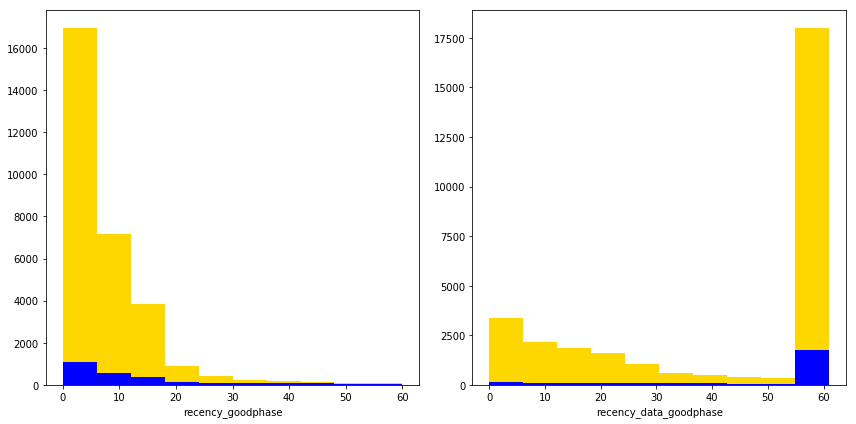

In [14]:
f, axes = plt.subplots(1, 2, figsize= (12, 6))
sns.distplot(telecom_df.recency_goodphase, color="gold", kde=False, hist_kws={"alpha": 1}, ax=axes[0], bins=10) 
sns.distplot(telecom_df[telecom_df.churn == 1].recency_goodphase, color="blue", kde=False, hist_kws={"alpha":1}, ax=axes[0], bins=10)

sns.distplot(telecom_df.recency_data_goodphase, color="gold", kde=False, hist_kws={"alpha": 1}, ax=axes[1], bins=10) 
sns.distplot(telecom_df[telecom_df.churn == 1].recency_data_goodphase, color="blue", kde=False, hist_kws={"alpha":1}, ax=axes[1],bins=10)
f.tight_layout()


### 3. Data volume consumed per rupee of recharge

In [15]:
#Data Volume of data used per rupee. (2gvol+3gvol)/av_rech_amt_data
for month in [6,7,8]:
    data_volm_used_per_rupee = 'data_volm_used_per_rupee_'+str(month)
    vol_3g_mb = 'vol_3g_mb_'+str(month)
    vol_2g_mb = 'vol_2g_mb_'+str(month)
    av_recharge = 'av_rech_amt_data_'+str(month)
    telecom_df.loc[telecom_df[av_recharge]==0, data_volm_used_per_rupee] =0
    telecom_df.loc[telecom_df[av_recharge]>0,data_volm_used_per_rupee] = (telecom_df[vol_2g_mb] + telecom_df[vol_3g_mb])/telecom_df[av_recharge]

/Users/aarora7/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


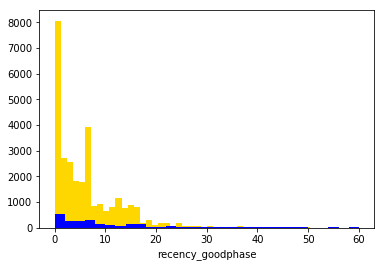

In [16]:
sns.distplot(telecom_df.recency_goodphase, color="gold", kde=False, hist_kws={"alpha": 1}) 
sns.distplot(telecom_df[telecom_df.churn == 1].recency_goodphase, color="blue", kde=False, hist_kws={"alpha":1}) 

### 4. Data heavy/ call heavy

In [17]:
for month in [6,7,8]: 
    colname = 'dataHeavy_'+str(month)
    total_amt_data = telecom_df['av_rech_amt_data_'+str(month)]
    total_amt_basic = telecom_df['total_rech_amt_'+str(month)]
    telecom_df[colname] = np.zeros(len(telecom_df))
    telecom_df.loc[total_amt_data >= total_amt_basic, colname] = 1

### 5. Good-phase aggregate variables

In [18]:
#The variables to combine in goodphase vs month8
cols_monthwise_67 =list(set(['_'.join(colm.split('_')[:-1]) for colm in telecom_df.columns if (colm.endswith('_6') or colm.endswith('_7'))]))

In [19]:
#aggregation techniques to combine columns from month 6 and 7 to goodphase vaiables
suffix = '_goodphase'
def agg_weighted_addtion(col):
    w_7 = 0.7 
    w_6 = 0.3
    telecom_df[col+suffix] = telecom_df[col+'_6']*w_6 + telecom_df[col+'_7']*w_7

def max_assign(col):
    telecom_df[col+suffix] = np.max(telecom_df[[col+'_6',col+'_7']], axis=1)    

def direct_assign(col):
    telecom_df[col+suffix] = telecom_df[col+'_7'] #more weight for 7th month
    #telecom_df[col+suffix] = telecom_df[col+suffix].apply(lambda num: 1 if num>1 else 0)

max_cols = ['max_rech_data','max_rech_amt']
continuity_cols = ['fb_user','night_pck_user','sachet_2g','sachet_3g','monthly_2g','monthly_3g','dataHeavy','last_day_rch_amt']
numeric_cols = [ 'loc_og_t2t_mou','loc_ic_t2m_mou','loc_ic_mou','total_rech_num', \
             'onnet_mou','count_rech_3g','vol_3g_mb','roam_ic_mou','loc_og_t2m_mou', \
             'total_rech_amt','loc_og_t2f_mou','std_og_t2m_mou','loc_og_t2c_mou','std_ic_t2f_mou', \
             'loc_ic_t2t_mou', 'total_rech_data','arpu_2g','count_rech_2g','roam_og_mou', \
             'og_others','loc_og_mou','std_og_mou','ic_others','total_og_mou','std_og_t2t_mou', \
             'arpu_3g','isd_og_mou','vol_2g_mb','isd_ic_mou','std_ic_mou','std_ic_t2m_mou', \
             'total_ic_mou','spl_ic_mou','spl_og_mou','std_ic_t2t_mou','loc_ic_t2f_mou', \
             'offnet_mou', 'std_og_t2f_mou','arpu','av_rech_amt_data','data_volm_used_per_rupee']


In [20]:
for col in numeric_cols:
    agg_weighted_addtion(col)
    
for col in continuity_cols:
    direct_assign(col)

for col in max_cols:
    max_assign(col)

for col in cols_monthwise_67:
    telecom_df = telecom_df.drop(col+'_6', axis=1)
    telecom_df = telecom_df.drop(col+'_7', axis=1)

In [21]:
#Correlation between variables in the goodphase
columns = [colm for colm in telecom_df.columns if colm.endswith('goodphase')]

In [22]:
data_regex = r'(3g|2g|data|fb|night_pck)'
data_based_columns = [colm for colm in columns if re.search(data_regex, colm)]
call_based_columns = list(set(columns).difference(set(data_based_columns)))

data_based_columns.append('churn')

In [23]:
def seaborn_lower_heatmap(data, figsize):
    
    # Compute the correlation matrix
    corr = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(25, 16))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                 linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


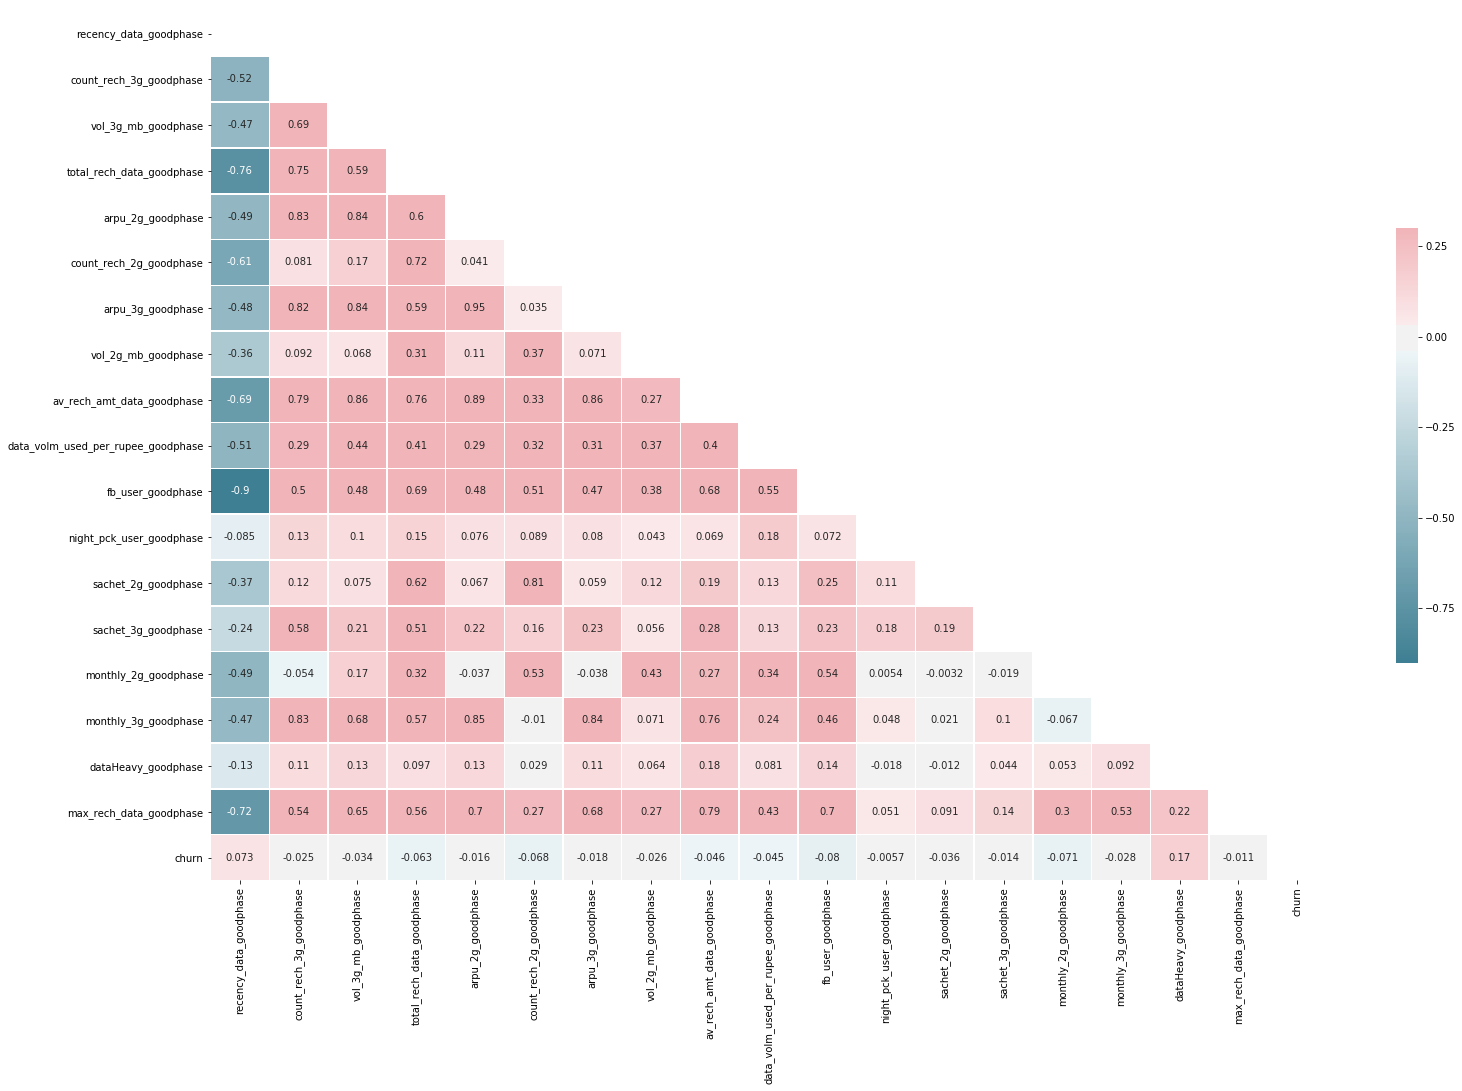

In [24]:
seaborn_lower_heatmap(telecom_df[data_based_columns],(15, 9))

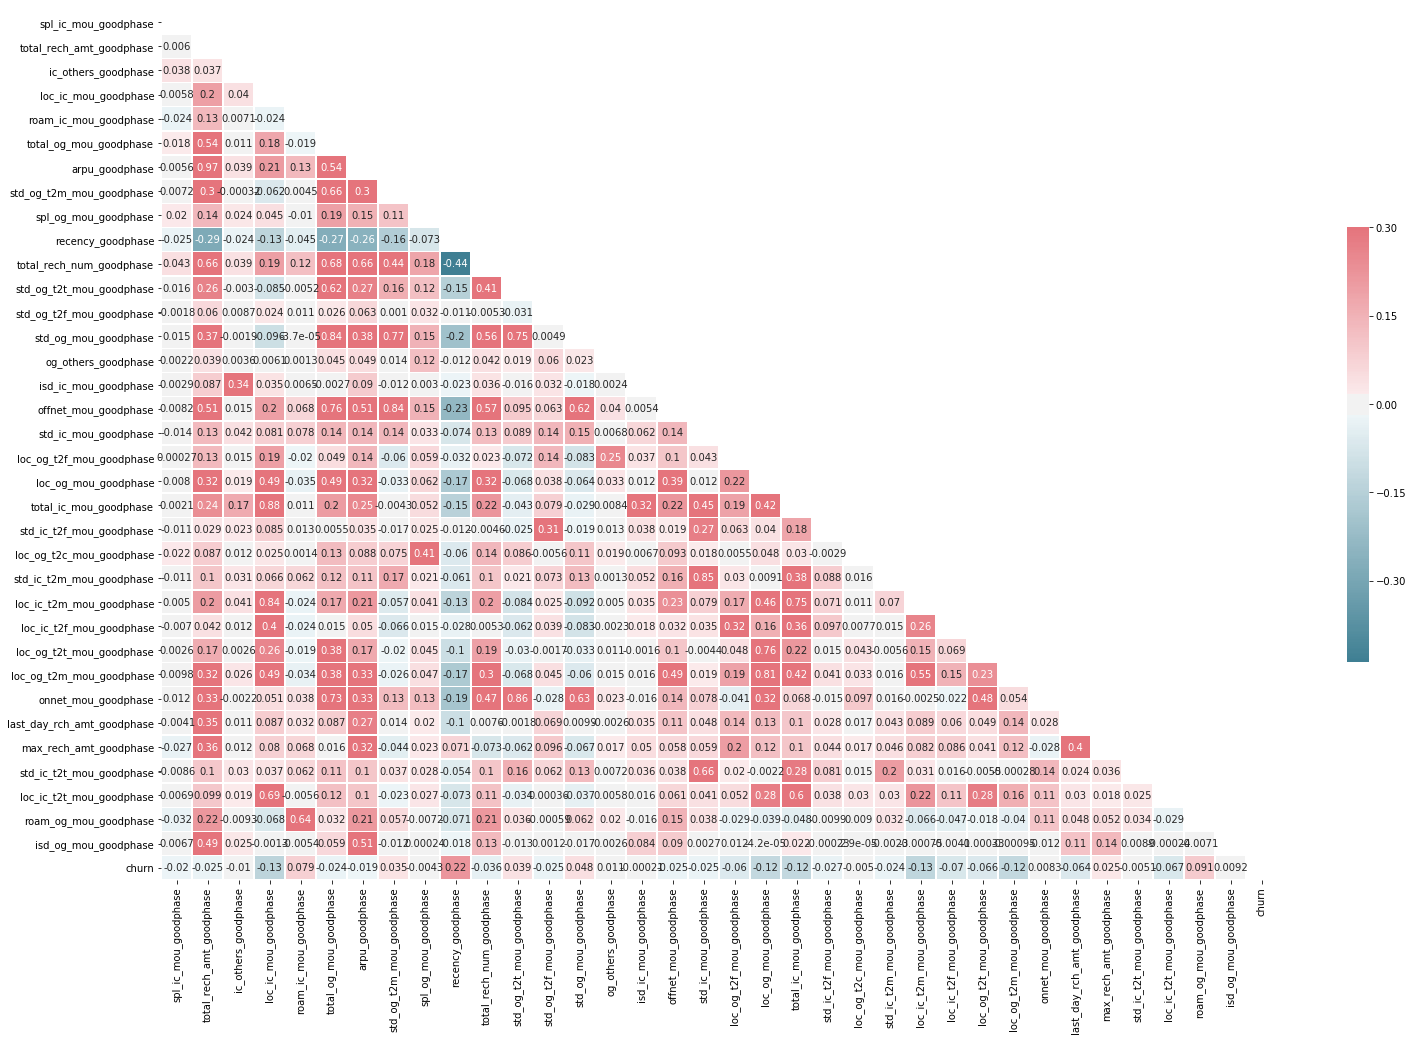

In [31]:
call_based_columns.append('churn')
seaborn_lower_heatmap(telecom_df[call_based_columns],(29, 19))

In [32]:
print(call_based_columns)

['spl_ic_mou_goodphase', 'total_rech_amt_goodphase', 'ic_others_goodphase', 'loc_ic_mou_goodphase', 'roam_ic_mou_goodphase', 'total_og_mou_goodphase', 'arpu_goodphase', 'std_og_t2m_mou_goodphase', 'spl_og_mou_goodphase', 'recency_goodphase', 'total_rech_num_goodphase', 'std_og_t2t_mou_goodphase', 'std_og_t2f_mou_goodphase', 'std_og_mou_goodphase', 'og_others_goodphase', 'isd_ic_mou_goodphase', 'offnet_mou_goodphase', 'std_ic_mou_goodphase', 'loc_og_t2f_mou_goodphase', 'loc_og_mou_goodphase', 'total_ic_mou_goodphase', 'std_ic_t2f_mou_goodphase', 'loc_og_t2c_mou_goodphase', 'std_ic_t2m_mou_goodphase', 'loc_ic_t2m_mou_goodphase', 'loc_ic_t2f_mou_goodphase', 'loc_og_t2t_mou_goodphase', 'loc_og_t2m_mou_goodphase', 'onnet_mou_goodphase', 'last_day_rch_amt_goodphase', 'max_rech_amt_goodphase', 'std_ic_t2t_mou_goodphase', 'loc_ic_t2t_mou_goodphase', 'roam_og_mou_goodphase', 'isd_og_mou_goodphase', 'churn']


telecom_df[call_based_columns].corr()['churn']
telecom_df[data_based_columns].corr()['churn']

In [168]:
temp = telecom_df.drop('mobile_number', axis=1)

In [169]:
hopkins(temp)

0.9851211435401603

## Splitting data

In [38]:
from sklearn.model_selection import train_test_split
# Putting feature variable to X
X = telecom_df.drop(['churn','mobile_number'],axis=1)
# Putting response variable to Y
Y = telecom_df['churn']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)